In [1]:
import logging
import os
from pathlib import Path
import shutil

import cm1.input.sounding
from cm1.run import PBS, CM1Run
from cm1.utils import skewt
import f90nml
from metpy.units import units
import pandas as pd

In [2]:
# Path to the CM1 repository
CM1 = Path(os.getenv("SCRATCH")) / "cm1"

testcase = "supercell"
run_dir = CM1 / f"run_{testcase}"
os.makedirs(run_dir, exist_ok=True)

# Copy all files from testcase configuration directory to run directory
shutil.copytree(CM1 / "run/config_files" / testcase, run_dir, dirs_exist_ok=True)

# Copy radiation data and model executable to run directory.
for file in ["RRTMG_LW_DATA", "RRTMG_SW_DATA", "cm1.exe"]:
    shutil.copy(CM1 / f"run/{file}", run_dir / file)

# Read Namelist object from namelist path.
namelist_path = run_dir / "namelist.input"
namelist = f90nml.read(namelist_path)

# Modify values in the namelist
namelist["param9"]["output_format"] = 2
namelist["param9"]["output_filetype"] = 1
namelist["param2"]["isnd"] = 7

# Write updated namelist in run directory.
namelist.write(namelist_path, force=True)
logging.info(f"Updated namelist saved to {namelist_path}")

valid_time = pd.to_datetime("20240525")
lon = -95 * units.degree_E
lat = 33 * units.degree_N

ds = cm1.input.sounding.era5_model_level(valid_time, lon=lon, lat=lat)
#ds = cm1.input.sounding.era5_aws(valid_time, lon=lon, lat=lat)
cm1.input.sounding.to_txt(ds)
ofile = run_dir / "input_sounding"
with open(ofile, "w") as f:
    f.write(cm1.input.sounding.to_txt(ds))
    logging.warning(ofile)

pbs_config = PBS(
    name=testcase,
    account="NMMM0021",
    walltime="01:00:00",
    nodes=1,
    run_dir=run_dir,
)
cm1_run = CM1Run(namelist=namelist, pbs_config=pbs_config)
#cm1_run.submit_job()
#cm1_run.run(background=False)

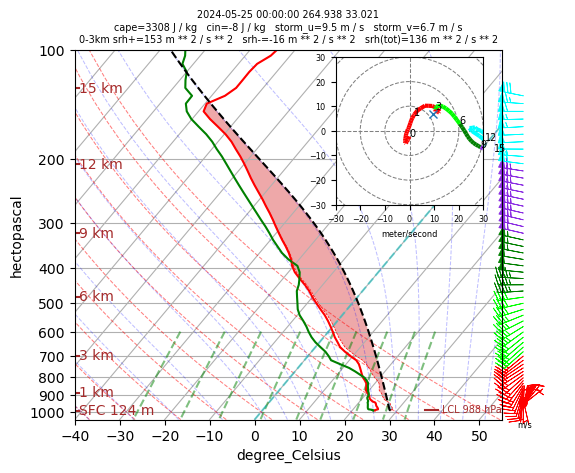

In [3]:
skewt(ds)